## Loading and Preposcessing the data 


In [1]:
import pandas as pd

In [2]:
df= pd.read_csv('AirlineTweets.csv')

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
df=df[['airline_sentiment','text']].copy()#removing all the other not using value

In [12]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [9]:
df.isnull().sum()# good practise

airline_sentiment    0
text                 0
dtype: int64

<Axes: >

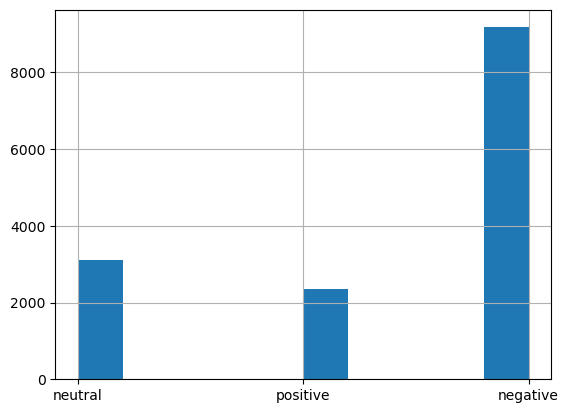

In [10]:
df['airline_sentiment'].hist()# the data is biased toward negative

In [15]:
value={'positive':1, 'negative': 0 ,'neutral':2}#correspomding to number
df['target']= df['airline_sentiment'].map(value)# we grab the airline_sentiment and map it for all 

In [16]:
df.head()

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [17]:
df1= df[['text','target']]
df1.columns= ['sentence','label']
df1.to_csv('data.csv',index=None)


In [19]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [20]:
from datasets import load_dataset
raw_dataset= load_dataset('csv', data_files='data.csv')# for multiple give list

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/abdur/.cache/huggingface/datasets/csv/default-5323811354345ef4/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [26]:
split= raw_dataset['train'].train_test_split(test_size=0.3)

In [27]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

## Model


In [46]:
checkpoints= 'distilbert-base-cased'# we are using distill bert for faster you use can other
 

In [47]:
from transformers import AutoTokenizer
tokenizer= AutoTokenizer.from_pretrained(checkpoints,token='yourtoken')


In [48]:
def tokenizer_fn(batch):
    return tokenizer(batch['sentence'],truncation=True)# this function tokenizer the data

In [50]:
tokenized_dataset= split.map(tokenizer_fn,batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [51]:
# now the data is completely processed
from transformers import AutoModelForSequenceClassification,Trainer, TrainingArguments

In [52]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoints,num_labels=3)

In [3]:
!pip install torchinfo



Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from torchinfo import summary 
summary(model)

In [ ]:
training_arg=TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64
)

In [2]:
from sklearn.metrics import f1_score
def compute_metrics(logits_and_labels):
    logits,label= logits_and_labels
    prediction = np.argmax(logits,axis=-1)
    acc =np.mean(prediction==label)
    f1=f1_score(labels,prediction,average='macro')
    return {'accuracy':acc,'f1':f1}

In [ ]:
trainer=Trainer(model,
                TrainingArguments,
                train_dataset=tokenized_dataset['train'],
                eval_dataset=tokenized_dataset['test'],
                tokenizer=tokenizer,
                compute_metrics=compute_metrics
                )

In [ ]:
trainer.train()

In [ ]:
!ls training_dir

In [ ]:
from transformer import pipeline
 

In [ ]:
savedmodel= pipeline('text-classification',model='training_dir/checkpoint-1282',device=0)

In [ ]:
test_pred= savedmodel(split['test']['sentence'])
test_pred

In [ ]:
def get_label(d):
    return int(d['label'.split('_')[1]])

test_pred=[get_label(d)for d in test_pred]

In [ ]:
print('acc:', accurary_score(split['test']['label']),test_pred)